In [ ]:
!pip install -q pytorch-lightning

# Imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
import matplotlib.pyplot as plt

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 45.1 MB/s eta 0:00:00
Using cpu


In [ ]:
# Transformation: Normalize and convert to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Scale to [-1, 1]
])

# Load MNIST training data
mnist_train = MNIST(root="./data", train=True, transform=transform, download=True)
mnist_loader = DataLoader(mnist_train, batch_size=128, shuffle=True, num_workers=2)

# Check one batch shape
images, labels = next(iter(mnist_loader))
print("Image batch shape:", images.shape)
print("Label batch shape:", labels.shape)


100%|██████████| 9.91M/9.91M [00:00<00:00, 52.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.63MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 11.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.66MB/s]


Image batch shape: torch.Size([128, 1, 28, 28])
Label batch shape: torch.Size([128])


In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_dim, label_dim, img_shape):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(10, label_dim)

        self.model = nn.Sequential(
            nn.Linear(noise_dim + label_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, int(torch.prod(torch.tensor(img_shape)))),
            nn.Tanh()
        )
        self.img_shape = img_shape

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        x = torch.cat((noise, label_input), dim=1)
        img = self.model(x)
        return img.view(img.size(0), *self.img_shape)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, label_dim, img_shape):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(10, label_dim)

        self.model = nn.Sequential(
            nn.Linear(label_dim + int(torch.prod(torch.tensor(img_shape))), 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_input = self.label_emb(labels)
        img_flat = img.view(img.size(0), -1)
        x = torch.cat((img_flat, label_input), dim=1)
        return self.model(x)


In [ ]:
class cGAN(pl.LightningModule):
    def __init__(self, noise_dim=100, label_dim=10, img_shape=(1, 28, 28), lr=0.0002):
        super().__init__()
        self.save_hyperparameters()
        self.generator = Generator(noise_dim, label_dim, img_shape)
        self.discriminator = Discriminator(label_dim, img_shape)
        self.loss = nn.BCELoss()
        self.automatic_optimization = False  # << Manual mode

    def forward(self, z, labels):
        return self.generator(z, labels)

    def training_step(self, batch, batch_idx):
        opt_g, opt_d = self.optimizers()
        real_imgs, labels = batch
        batch_size = real_imgs.size(0)

        # Train Discriminator
        real_validity = self.discriminator(real_imgs, labels)
        real_loss = self.loss(real_validity, torch.ones_like(real_validity))
        z = torch.randn(batch_size, self.hparams.noise_dim, device=self.device)
        fake_imgs = self(z, labels).detach()
        fake_validity = self.discriminator(fake_imgs, labels)
        fake_loss = self.loss(fake_validity, torch.zeros_like(fake_validity))
        d_loss = (real_loss + fake_loss) / 2
        opt_d.zero_grad()
        self.manual_backward(d_loss)
        opt_d.step()

        # Train Generator
        z = torch.randn(batch_size, self.hparams.noise_dim, device=self.device)
        gen_imgs = self(z, labels)
        validity = self.discriminator(gen_imgs, labels)
        g_loss = self.loss(validity, torch.ones_like(validity))
        opt_g.zero_grad()
        self.manual_backward(g_loss)
        opt_g.step()
        self.log("g_loss", g_loss, prog_bar=True)
        self.log("d_loss", d_loss, prog_bar=True)

    def configure_optimizers(self):
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=self.hparams.lr, betas=(0.5, 0.999))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=self.hparams.lr, betas=(0.5, 0.999))
        return [opt_g, opt_d]

In [ ]:
# Hyperparameters
noise_dim = 100
label_dim = 10
img_shape = (1, 28, 28)
lr = 0.0002
epochs = 20

# Initialize the model
model = cGAN(noise_dim=noise_dim, label_dim=label_dim, img_shape=img_shape, lr=lr)

# Lightning Trainer
trainer = pl.Trainer(
    max_epochs=epochs,
    accelerator="auto",
    devices=1,  # Always set to 1 regardless of GPU or CPU
    log_every_n_steps=50
)


# Train
trainer.fit(model, mnist_loader)


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 582 K  | train
1 | discriminator | Discriminator | 538 K  | train
2 | loss          | BCELoss       | 0      | train
--------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.485     Total estimated model params size (MB)
23        Module

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


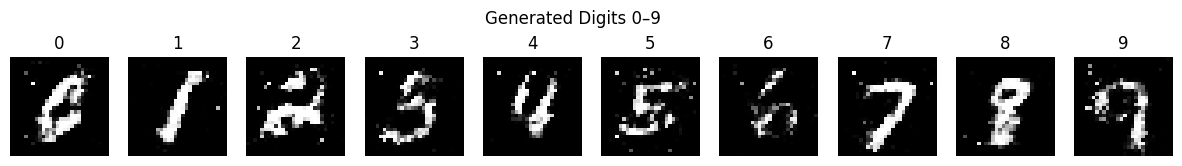

In [ ]:
import numpy as np

def generate_digit_grid(model, noise_dim=100):
    model.eval()
    # Generate one image per digit label (0 to 9)
    n_digits = 10
    z = torch.randn(n_digits, noise_dim).to(model.device)
    labels = torch.arange(0, n_digits).to(model.device)
    with torch.no_grad():
        generated_imgs = model(z, labels)
        generated_imgs = generated_imgs.cpu().numpy()
    # Plot the results
    fig, axs = plt.subplots(1, 10, figsize=(15, 2))
    for i in range(n_digits):
        axs[i].imshow(generated_imgs[i][0], cmap="gray")
        axs[i].axis("off")
        axs[i].set_title(str(i))
    plt.suptitle("Generated Digits 0–9")
    plt.show()
# Run the function
generate_digit_grid(model)


In [ ]:
def generate_specific_digit(model, digit, noise_dim=100):
    assert 0 <= digit <= 9, "Digit must be between 0 and 9"
    model.eval()
    z = torch.randn(1, noise_dim).to(model.device)
    label = torch.tensor([digit]).to(model.device)
    with torch.no_grad():
        generated_img = model(z, label)
        img = generated_img[0][0].cpu().numpy()
    plt.imshow(img, cmap='gray')
    plt.title(f"Generated Digit: {digit}")
    plt.axis('off')
    plt.show()

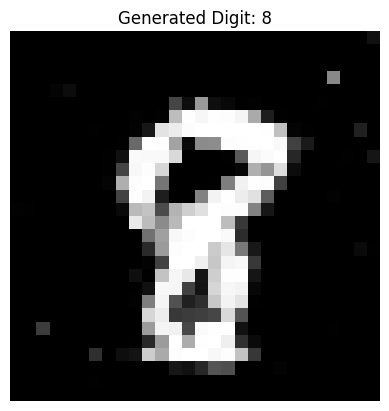

In [ ]:
generate_specific_digit(model, digit=8)